<a id='top'></a>

### Assignment: Spam Detection

- <a href='#preprocessingbagofwords'>Preprocessing for Bag Of Words</a>

- <a href='#modelselectionbagofwords'>Model Selection for Bag Of Words</a>

- <a href='#preprocessingtfidf'>Preprocessing for Tfidf</a>

- <a href='#modelselectiontfidf'>Model Selection for Tfidf</a>

- <a href='#optimization'>Optimization</a>

In [14]:
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import nltk
import re

# preprocessing
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from scipy.sparse import csr_matrix

# model selection
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

# metrics and visualization
from sklearn.metrics import accuracy_score, confusion_matrix, auc, roc_curve

sb.set()

In [2]:
def fix_heatmap(title):
    bottom, top = plt.ylim()
    bottom += 0.5 
    top -= 0.5
    plt.ylim(bottom, top)
    plt.title(f'Confusion Matrix for {title}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
def summarize(results):
    return pd.DataFrame(list(zip(results['title'], results['accuracy'], results['ravel'],
                                 results['PPV'], results['NPV'], results['auc'])),
                        columns = ['Titles', 'Classif Acc', 'TN, FP, FN, TP', 'PPV', 'NPV', 'AUC'])

In [3]:
def analyze(y_true, y_pred, X_test, model, results, title):
    cm = confusion_matrix(y_true, y_pred)
    sb.heatmap(cm, annot = True, fmt=".0f", annot_kws={"size": 18}, 
               xticklabels = ['good', 'spam'], yticklabels = ['good', 'spam'])
    fix_heatmap(title)
    tn, fp, fn, tp = cm.ravel()
    ppv = np.round(tp / (tp + fp), 3)
    npv = np.round(tn / (tn + fn), 3)
    
    results['accuracy'].append(np.round(accuracy_score(y_true, y_pred), 3))
    results['ravel'].append(cm.ravel())
    results['PPV'].append(ppv)
    results['NPV'].append(npv)

    results['title'].append(title)
    
    area_under_curve = visualize_roc(y_true, X_test, model, title)
    results['auc'].append(area_under_curve)
    
    return results

In [4]:
def visualize_roc(y_true, X_test, model, title):
    fpr, tpr, thr = roc_curve(y_true, model.predict_proba(X_test)[:,1], pos_label = 'spam')
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC for {title}')
    area_under_curve = auc(fpr, tpr)
    plt.legend(["AUC {0:.2f}".format(area_under_curve)])
    plt.show()
    return round(area_under_curve, 3)

In [5]:
def run_model(features, response, model, results, title):
    X_train, X_test, y_train, y_test = train_test_split(features, response, test_size = 0.25, 
                                                        random_state = 1)
    model.fit(X_train, y_train)
    y_test_pred = model.predict(X_test)
    
    results = analyze(y_test, y_test_pred, X_test, model, results, title)
    summary = summarize(results)
    results['summary'] = summary
    return results

<a id='preprocess()'></a>
<a href='#top'>Back to top</a>

In [6]:
def preprocess(text):
    # lower case and remove special characters\whitespaces
    # re.I ignore cases, re.A ASCII onl matching
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    text = text.lower()
    text = text.strip()
    
    tokenizer = nltk.WordPunctTokenizer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    stemmer = nltk.stem.PorterStemmer()
    stop_words = nltk.corpus.stopwords.words('english')

    tokens = tokenizer.tokenize(text)
    # filter stopwords out of text
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create text from filtered tokens
    text = ' '.join(filtered_tokens)
    # reduce each word to root form
    # for example, running and ran becomes run
    lemmatized_text = lemmatizer.lemmatize(text, pos = 'v')
    stemmed_text = stemmer.stem(lemmatized_text)
    # 2 extra features
    num_words = len(filtered_tokens)
    num_letters = len(text)
    
    return stemmed_text, num_words, num_letters

In [7]:
# Read the dataset as per the format
# response label <tab> sms as string
smsData = pd.read_table('smsdata.txt', sep = "\t", header = None)
smsData.head()

,0,1
0,good,"Go until jurong point, crazy.. Available only ..."
1,good,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,good,U dun say so early hor... U c already then say...
4,good,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# Fix the headers / column labels
smsData.columns = ["label", "text"]
smsData.head()

,label,text
0,good,"Go until jurong point, crazy.. Available only ..."
1,good,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,good,U dun say so early hor... U c already then say...
4,good,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# Basic information about the data
smsData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
label    5572 non-null object
text     5572 non-null object
dtypes: object(2)
memory usage: 87.2+ KB


Peak at some of the `spam` and `good` sms

In [10]:
condition = smsData['label'] == 'spam'
smsData[condition].head()

,label,text
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...
11,spam,"SIX chances to win CASH! From 100 to 20,000 po..."


In [11]:
smsData[~condition].head()

,label,text
0,good,"Go until jurong point, crazy.. Available only ..."
1,good,Ok lar... Joking wif u oni...
3,good,U dun say so early hor... U c already then say...
4,good,"Nah I don't think he goes to usf, he lives aro..."
6,good,Even my brother is not like to speak with me. ...


<a id='preprocessingbagofwords'></a>
### Preprocessing for Bag Of Words

Clean the text data with <a href='#preprocess()'>preprocess()</a> and apply `CountVectorizer`

<a href='#preprocess()'>preprocess()</a> removes all punctuations and stopwords, converts all text to lowercase and reduces each word root form.

[CountVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html): Convert a collection of text documents to a matrix of token counts

See <a href='#countvectorizer'>here</a> for the result

<a href='#top'>Back to top</a>

In [16]:
# vectorize allows for vector input into function
v_preprocess = np.vectorize(preprocess)

cleanData, num_words, num_letters = v_preprocess(smsData['text'])
# apply CountVectorizer, counting each word and phrase up to 5 words long
cv = CountVectorizer(min_df=0., max_df=1., analyzer = 'word', ngram_range = (1, 5))
cv_matrix = cv.fit_transform(cleanData)
cv_matrix = cv_matrix.toarray()

# get all unique words in the corpus
vocab = cv.get_feature_names()

In [18]:
cv_matrix.shape

(5572, 118964)

Here `num_words` and `num_letters` are compared with `label` to see if they should be used as features

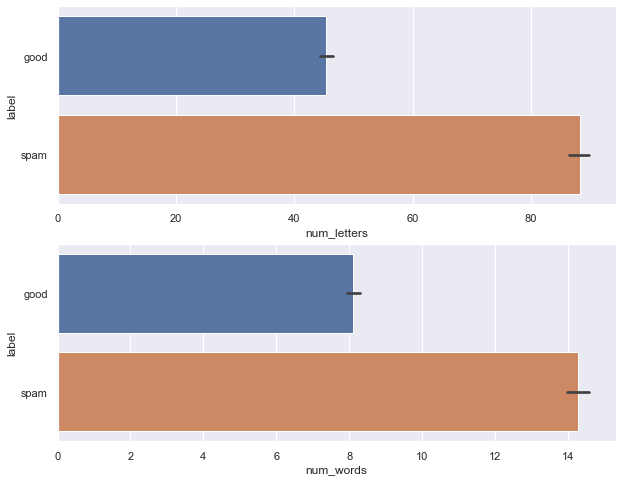

In [13]:
smsData['num_words'] = num_words
smsData['num_letters'] = num_letters
byLetters = smsData.sort_values(by = 'num_letters', ascending = False)
byWords = smsData.sort_values(by = 'num_letters', ascending = False)

f, axes = plt.subplots(2, 1, figsize = (10, 8))

sb.barplot(x = 'num_letters', y = 'label', data = byLetters, ax = axes[0])
sb.barplot(x = 'num_words', y = 'label', data = byWords, ax = axes[1])

Above shows higher `num_letters` and `num_words` seem to indicate `spam` sms

<a id='countvectorizerresult'></a>
<a href='#preprocessingbagofwords'>Back to preprocessing()</a>

In [14]:
# show document feature vectors
features = pd.DataFrame(cv_matrix, columns=vocab)
features['num_words'] = num_words
features['num_letters'] = num_letters
features.head()

,aa,aa exhaust,aa exhaust hang,aah,aah bless,aah bless hows,aah bless hows arm,aah cuddle,aah cuddle would,aah cuddle would lush,...,zs,zs subscription,zs subscription pw,zyada,zyada kisi,zyada kisi ko,zyada kisi ko kuch,zyada kisi ko kuch nahi,num_words,num_letters
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,16,82
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,23
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,20,107
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,35
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,43


The above is a very sparse matrix that counts how many times a word or phrase appears in each sms, and the number of letters and words for each sms. In other words, `features['call']` only has values 0, 1, 2, 3 as call appears no more than 3 times per sms as seen below.
<a id='#countvectorizerresult'></a>
See <a href='#preprocessingtfidf'>here</a> for apply `Tfidf` instead of `CountVectorizer` to count the 

In [15]:
features.call.value_counts()

0    5100
1     444
2      26
3       2
Name: call, dtype: int64

<a id='modelselectionbagofwords'></a>
### Model selection
<a href='#top'>Back to top</a>

Here `DecisionTreeClassifier` will be compared to `RandomForestClassifier` based mainly on `PPV` and `NPV` to determine better model.

Intuitively:
- `PPV == 1` represents zero `good` sms classified as `spam`
- `NPV == 1` represents zero `spam` sms classified as `good`

The aim should be to prioritize maximizing `PPV` over `NPV` although having both == 1 is ideal. In other words, considering email, it is important to have zero `good` emails going into the `spam` folder and having an occassional `spam` email in inbox is forgivable.

Description | Formula
--- | ---
sensitivity, recall, hit rate, or true positive rate (TPR) | TPR = $\frac{TP}{P}$ = $\frac{TP}{TP+FN}$ = 1-*FNR*
specificity, selectivity or true negative rate (TNR) | TNR = $\frac{TN}{N}$ = $\frac{TN}{TN+FP}$ = 1-*FPR*
precision or positive predictive value (PPV): | PPV = $\frac{TP}{TP+FP}$ = 1-*FDR*
negative predictive value (NPV): | NPV = $\frac{TN}{TN+FN}$ = 1-*FOR*
miss rate or false negative rate (FNR): | FNR = $\frac{TN}{P}$ = $\frac{FN}{FN+TP}$ = 1-*TPR*
fall-out or false positive rate (FPR): | FPR = $\frac{FP}{N}$ = $\frac{FP}{FP+TN}$ = 1-*TNR*
false discovery rate (FDR): | FDR = $\frac{FP}{FP+TP}$ = 1-*PPV*
false omission rate (FOR): | FOR = $\frac{FN}{FN+TN}$ = 1-*NPV*
Threat score (TS) or Critical Success Index (CSI): | TS = $\frac{TP}{TP+FN+FP}$

In [16]:
results = {'accuracy': [],
           'ravel': [],
           'PPV': [],
           'NPV': [],
           'auc': [],
           'title': []}

In [17]:
%%time
# convert to sparse matrix for efficient model trainig
features = csr_matrix(features.values)
response = smsData['label']

Wall time: 23.7 s


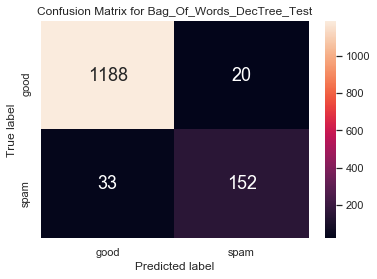

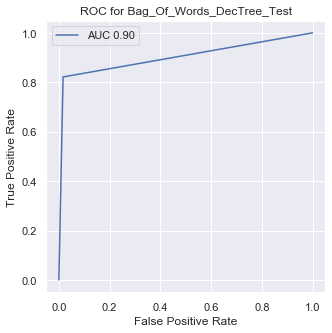

C:\Users\Nicholas\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


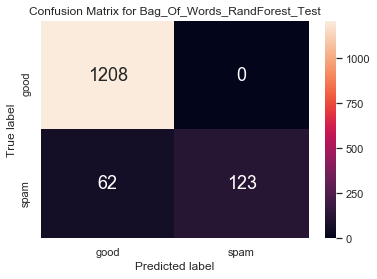

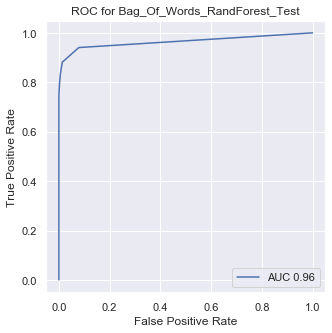

,Titles,Classif Acc,"TN, FP, FN, TP",PPV,NPV,AUC
0,Bag_Of_Words_DecTree_Test,0.962,"[1188, 20, 33, 152]",0.884,0.973,0.903
1,Bag_Of_Words_RandForest_Test,0.955,"[1208, 0, 62, 123]",1.000,0.951,0.965


In [18]:
results = run_model(features, response, DecisionTreeClassifier(random_state = 1), 
                    results, 'Bag_Of_Words_DecTree_Test')
results = run_model(features, response, RandomForestClassifier(random_state = 1), 
                    results, 'Bag_Of_Words_RandForest_Test')
results['summary']

`RandomForest` outperforms `DecisionTree` here. Ideally, `area_under_curve`(`AUC`) should be == 1

`AUC`: Rate of true positives and false positives for all threshold values of predicted labels and plot the results. [Read more](https://www.jamesmaino.com/post/simple-intuitive-explanation-of-roc-and-auc-curves/)

<a id='preprocessingtfidf'></a>
### Preprocessing for Tfidf

[Tfidf](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html): Term-Frequency times Inverse-Document-Frequency. 

The goal of using tf-idf instead of the raw frequencies of occurrence of a token in a given document is to scale down the impact of tokens that occur very frequently in a given corpus and that are hence empirically less informative than features that occur in a small fraction of the training corpus.

<a href='#countvectorizerresult'>Back to CountVectorizer result</a>

<a href='#top'>Back to top</a>

In [19]:
cleanData, num_words, num_letters = v_preprocess(smsData['text'])
cv = CountVectorizer(min_df=0., max_df=1., analyzer = 'word', ngram_range = (1, 5))
cv_matrix = cv.fit_transform(cleanData)

# get all unique words in the corpus
vocab = cv.get_feature_names()
tfidf_transformed = TfidfTransformer().fit_transform(cv_matrix)
tfidf_transformed = tfidf_transformed.toarray()

features = pd.DataFrame(tfidf_transformed, columns=vocab)
features['num_words'] = num_words
features['num_letters'] = num_letters
features.head()

,aa,aa exhaust,aa exhaust hang,aah,aah bless,aah bless hows,aah bless hows arm,aah cuddle,aah cuddle would,aah cuddle would lush,...,zs,zs subscription,zs subscription pw,zyada,zyada kisi,zyada kisi ko,zyada kisi ko kuch,zyada kisi ko kuch nahi,num_words,num_letters
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16,82
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,23
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,20,107
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9,35
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8,43


<a id='tfidf'></a>
Using Tfidf instead of `CountVectorizer`

<a href='#preprocessingbagofwords'>Back to preprocessing for Bag Of Words</a>

<a href='#top'>Back to top</a>

In [20]:
features.call.value_counts()

0.000000    5100
0.202223      30
0.079436       7
0.074982       4
0.138217       4
            ... 
0.053924       1
0.044266       1
0.172493       1
0.069919       1
0.049611       1
Name: call, Length: 350, dtype: int64

As seen, instead of counting how many times `call` appear in a sms, `Tfidf` takes into account the frequency of occurence and scales accordingly

In [21]:
%%time
# convert to sparse matrix for more efficient training of model
features = csr_matrix(features.values)

Wall time: 29.3 s


<a id='modelselectiontfidf'></a>
### Model Selection for Tfidf
<a href='#top'>Back to top</a>

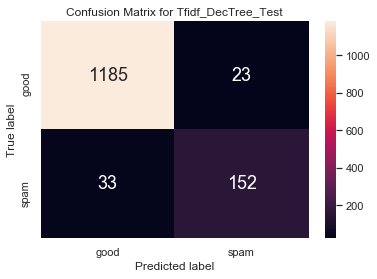

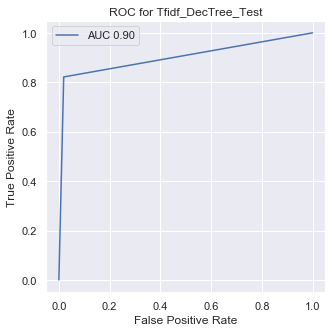

C:\Users\Nicholas\AppData\Roaming\Python\Python36\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


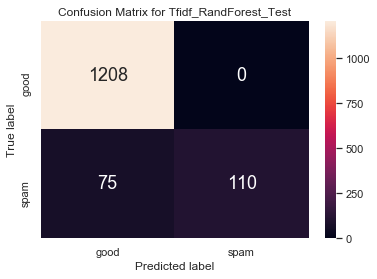

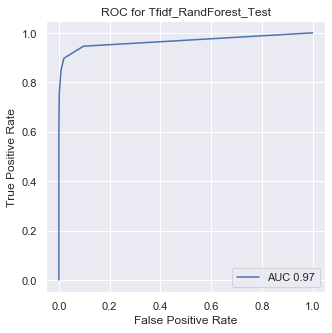

,Titles,Classif Acc,"TN, FP, FN, TP",PPV,NPV,AUC
0,Bag_Of_Words_DecTree_Test,0.962,"[1188, 20, 33, 152]",0.884,0.973,0.903
1,Bag_Of_Words_RandForest_Test,0.955,"[1208, 0, 62, 123]",1.000,0.951,0.965
2,Tfidf_DecTree_Test,0.960,"[1185, 23, 33, 152]",0.869,0.973,0.901
3,Tfidf_RandForest_Test,0.946,"[1208, 0, 75, 110]",1.000,0.942,0.966


In [22]:
results = run_model(features, response, DecisionTreeClassifier(random_state = 1),
                    results, 'Tfidf_DecTree_Test')
results = run_model(features, response, RandomForestClassifier(random_state = 1),
                    results, 'Tfidf_RandForest_Test')
results['summary']

`RandomForest` outperforms `DecisionTree` again. Using `Bag Of Words` seem to outperform `Tfidf`. Next, optimize on both `Bag of Words` and `Tfidf` with `cross validation` to be sure

<a id='optimization'></a>
### Optimization
<a href='#top'>Back to top</a>

In [23]:
%%time
# try models with these parameters and choosing best
parameters = {'min_samples_leaf': range(1, 3, 1), 'min_samples_split': range(2, 13, 2), 
              'n_estimators': range(10, 21, 5)}
model = RandomForestClassifier(random_state=1)
clf = GridSearchCV(model, parameters, scoring='roc_auc', cv = 5)
clf.fit(features, response)
clf.best_score_

Wall time: 5min 34s


0.9802872927230436

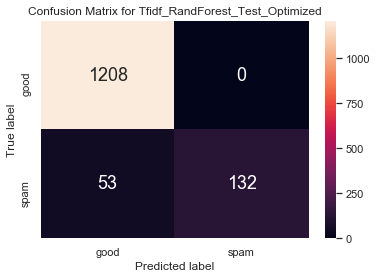

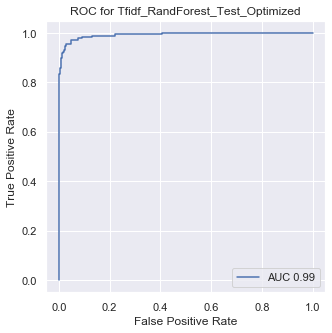

,Titles,Classif Acc,"TN, FP, FN, TP",PPV,NPV,AUC
0,Bag_Of_Words_DecTree_Test,0.962,"[1188, 20, 33, 152]",0.884,0.973,0.903
1,Bag_Of_Words_RandForest_Test,0.955,"[1208, 0, 62, 123]",1.000,0.951,0.965
2,Tfidf_DecTree_Test,0.960,"[1185, 23, 33, 152]",0.869,0.973,0.901
3,Tfidf_RandForest_Test,0.946,"[1208, 0, 75, 110]",1.000,0.942,0.966
4,Tfidf_RandForest_Test_Optimized,0.962,"[1208, 0, 53, 132]",1.000,0.958,0.993


In [24]:
# looking at the optimized model
results = run_model(features, response, clf.best_estimator_,
                    results, 'Tfidf_RandForest_Test_Optimized')
results['summary']

Repeat the process with `CountVectorizer`

In [25]:
cleanData, num_words, num_letters = v_preprocess(smsData['text'])
cv = CountVectorizer(min_df=0., max_df=1., analyzer = 'word', ngram_range = (1, 5))
cv_matrix = cv.fit_transform(cleanData)
cv_matrix = cv_matrix.toarray()

# get all unique words in the corpus
vocab = cv.get_feature_names()

features = pd.DataFrame(cv_matrix, columns=vocab)
features['num_words'] = num_words
features['num_letters'] = num_letters
features.head()

,aa,aa exhaust,aa exhaust hang,aah,aah bless,aah bless hows,aah bless hows arm,aah cuddle,aah cuddle would,aah cuddle would lush,...,zs,zs subscription,zs subscription pw,zyada,zyada kisi,zyada kisi ko,zyada kisi ko kuch,zyada kisi ko kuch nahi,num_words,num_letters
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,16,82
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,6,23
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,20,107
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,9,35
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,8,43


In [26]:
%%time
features = csr_matrix(features.values)

Wall time: 34.1 s


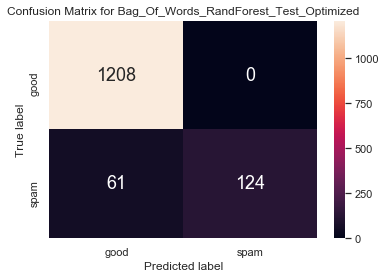

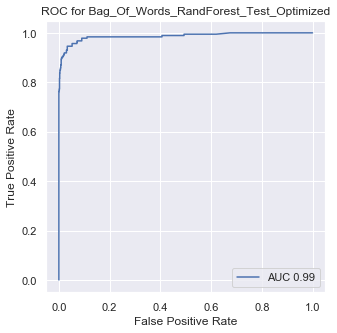

Wall time: 6min 1s


,Titles,Classif Acc,"TN, FP, FN, TP",PPV,NPV,AUC
0,Bag_Of_Words_DecTree_Test,0.962,"[1188, 20, 33, 152]",0.884,0.973,0.903
1,Bag_Of_Words_RandForest_Test,0.955,"[1208, 0, 62, 123]",1.000,0.951,0.965
2,Tfidf_DecTree_Test,0.960,"[1185, 23, 33, 152]",0.869,0.973,0.901
3,Tfidf_RandForest_Test,0.946,"[1208, 0, 75, 110]",1.000,0.942,0.966
4,Tfidf_RandForest_Test_Optimized,0.962,"[1208, 0, 53, 132]",1.000,0.958,0.993
5,Bag_Of_Words_RandForest_Test_Optimized,0.956,"[1208, 0, 61, 124]",1.000,0.952,0.987


In [27]:
%%time

parameters = {'min_samples_leaf': range(1, 3, 1), 'min_samples_split': range(2, 13, 2), 
              'n_estimators': range(10, 21, 5)}
model = RandomForestClassifier(random_state=1)
clf = GridSearchCV(model, parameters, scoring='roc_auc', cv = 5)
clf.fit(features, response)
clf.best_score_

results = run_model(features, response, clf.best_estimator_,
                    results, 'Bag_Of_Words_RandForest_Test_Optimized')
results['summary']

From the results, using `Tfidf` and `RandomForest` with optimized parameters give the best results

- `PPV` == 1 meaning zero `good` messages classified as `spam`
- `NPV` == 0.958, considering the email example again, meaning 0.042% of spam messages got through into inbox

<a href='#top'>Back to top</a>